In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
print(train.shape)
print(test.shape)

(567730, 83)
(243313, 82)


Training dataset contains 567730 rows(records) and 83 columns(features)

In [4]:
train['HasDetections'].value_counts()

0    482571
1     85159
Name: HasDetections, dtype: int64

#### This is a binary classification problem. But this is an imbalanced dataset based on count of target 'HasDetections'. There are more no of values of '0 class' than '1 class' . approx -> (1:6 ratio)

In [156]:
## datatypes and no of missing values in each feature column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567730 entries, 0 to 567729
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  567730 non-null  object 
 1   ProductName                                        567730 non-null  object 
 2   EngineVersion                                      567730 non-null  object 
 3   AppVersion                                         567730 non-null  object 
 4   AvSigVersion                                       567730 non-null  object 
 5   IsBeta                                             567730 non-null  int64  
 6   RtpStateBitfield                                   565573 non-null  float64
 7   IsSxsPassiveMode                                   567730 non-null  int64  
 8   DefaultBrowsersIdentifier                          29528 non-null   float6

Train dataset has 83 columns, among which "HasDetections" is target column. There are 30 columns with categorical data (non-numerical)

#### Missing Values Handling

About 44 features have missing values in them. we shall perform missing data analysis for each type of datatype seperately 

In [157]:
## missing value counts of categorical(object) types
a = train.dtypes[train.dtypes == 'object'].index
(train[a].isna().sum()/train.shape[0]).sort_values(ascending=False).head(10)

PuaMode                         0.999813
Census_ProcessorClass           0.996121
Census_InternalBatteryType      0.704557
SmartScreen                     0.365272
Census_PrimaryDiskTypeName      0.001457
Census_ChassisTypeName          0.000070
Census_PowerPlatformRoleName    0.000009
OsBuildLab                      0.000002
SkuEdition                      0.000000
Census_FlightRing               0.000000
dtype: float64

There are 8 columns of object dtype with missing values. "PuaMode" feature being with highest with almost 99% missing values.

In [158]:
## missing value counts of float types
b = train.dtypes[train.dtypes == 'float'].index
(train[b].isna().sum()/train.shape[0]).sort_values(ascending=False)

DefaultBrowsersIdentifier                            0.947989
Census_IsFlightingInternal                           0.827571
Census_ThresholdOptIn                                0.631275
Census_IsWIMBootEnabled                              0.630317
OrganizationIdentifier                               0.309818
SMode                                                0.067842
CityIdentifier                                       0.036826
Wdft_IsGamer                                         0.033347
Wdft_RegionIdentifier                                0.033347
Census_InternalBatteryNumberOfCharges                0.028239
Census_FirmwareManufacturerIdentifier                0.022759
Census_FirmwareVersionIdentifier                     0.019884
Census_IsFlightsDisabled                             0.017480
Census_OEMModelIdentifier                            0.011865
Census_OEMNameIdentifier                             0.011111
Firewall                                             0.010184
Census_T

There are 50 columns of float dtype having missing values. "DefaultBrowsersIdentifier" feature being with highest = 94.7% and "GeoNameIdentifier" with lowest -> 0.0032%

In [159]:
## missing value counts of int types
c = train.dtypes[train.dtypes == 'int64'].index
train[c].isna().sum().sort_values(ascending=False).head()

HasDetections        0
AutoSampleOptIn      0
IsSxsPassiveMode     0
HasTpm               0
CountryIdentifier    0
dtype: int64

As we can see, columns with int dtypes having no missing values. So we only have to deal with columns of object and float datatypes.

Two features "PuaMode", "Census_ProcessorClass" have about 99% missing values, meaning almost empty. It makes sense to drop these columns completely.

In [5]:
train.drop('PuaMode',inplace=True, axis=1)
train.drop('Census_ProcessorClass',inplace=True, axis=1)
test.drop('PuaMode', inplace=True, axis=1)
test.drop('Census_ProcessorClass', inplace=True, axis=1)

In [7]:
train["Census_InternalBatteryType"].value_counts()

lion        132394
li-i         15971
#            11383
lip           3816
liio          2154
li p           464
li             454
nimh           329
bq20           207
real           177
vbox           151
pbac           108
unkn            43
lgi0            25
lhp0            15
4cel             9
lipo             8
ithi             4
lipp             4
pad0             3
virt             3
batt             3
ots0             2
ca48             1
#TAB#            1
l&#TAB#         1
8                1
li-p             1
Name: Census_InternalBatteryType, dtype: int64

Because of the presence of vague values in Battery_type_column, & for the sake of simplicity, lets club other than lion batteries into another value - 'non-lion' since most modern batteries are lithium lion based. This will also eventually fill the missing values.

In [6]:
## filling values with lion as 1 as others as 0, same change reflected in test dataset
def filter_batteries(bat):
    bat = str(bat)
    if 'li' in bat:
        return 1
    else:
        return 0

train["Census_InternalBatteryType"] = train["Census_InternalBatteryType"].apply(filter_batteries)
test["Census_InternalBatteryType"] = test["Census_InternalBatteryType"].apply(filter_batteries)

In [7]:
train['SmartScreen'].value_counts()

RequireAdmin    298936
ExistsNotSet     37910
Off              11932
Warn              7676
Prompt            2288
Block             1432
off                 75
On                  52
&#x02;              26
&#x01;              15
on                   9
OFF                  2
requireadmin         1
Name: SmartScreen, dtype: int64

Similar situation arises in Smart_Screen feature, but here the values are repeated in different form of words, so we need to clean whichever have special chars and convert similar words to single root form

In [7]:
conversion_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}
train.replace({'SmartScreen': conversion_dict}, inplace=True)
test.replace({'SmartScreen': conversion_dict}, inplace=True)

For features "Smart_screen", "Disk_Type", "Chassis_Type", "PowerPlatformRole", "OSBuild_Lab", we shall fill mode value for missing values in these. The reasoning is that people use computer parts that are most popular / or used by majority people.

In [8]:
for column in ['SmartScreen', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'OsBuildLab']:
    train[column].fillna(train[column].mode()[0], inplace=True)
    test[column].fillna(test[column].mode()[0], inplace=True)

We shall fill remaining columns of float dtype with mode values too for now to make it easier for EDA Analysis. Later we can change if required in Feature Engineering.

In [9]:
for feature in ["DefaultBrowsersIdentifier", "Census_IsFlightingInternal", "Census_ThresholdOptIn", "Census_IsWIMBootEnabled", "OrganizationIdentifier", "SMode", "CityIdentifier", "Wdft_IsGamer", "Wdft_RegionIdentifier", "Census_InternalBatteryNumberOfCharges", "Census_FirmwareManufacturerIdentifier", "Census_FirmwareVersionIdentifier", "Census_IsFlightsDisabled", "Census_OEMModelIdentifier", "Census_OEMNameIdentifier", "Firewall", "Census_TotalPhysicalRAM", "Census_IsAlwaysOnAlwaysConnectedCapable", "Census_OSInstallLanguageIdentifier", "IeVerIdentifier", "Census_SystemVolumeTotalCapacity", "Census_PrimaryDiskTotalCapacity", "Census_InternalPrimaryDiagonalDisplaySizeInInches", "Census_InternalPrimaryDisplayResolutionHorizontal", "Census_InternalPrimaryDisplayResolutionVertical", "AVProductsEnabled", "AVProductsInstalled", "AVProductStatesIdentifier", "IsProtected", "Census_ProcessorModelIdentifier", "Census_ProcessorCoreCount", "Census_ProcessorManufacturerIdentifier", "RtpStateBitfield", "Census_IsVirtualDevice", "UacLuaenable", "GeoNameIdentifier"]:
    train[feature].fillna(train[feature].mode()[0], inplace=True)
    test[feature].fillna(test[feature].mode()[0], inplace=True)

### Univariate Analysis

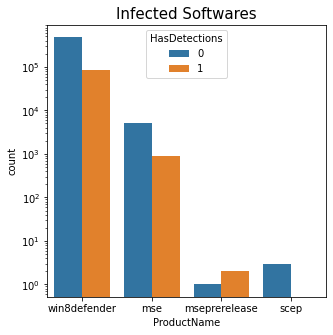

In [183]:
## Antivirus Product name vs Detection target

plt.figure(figsize = (5,5))
sns.countplot(x='ProductName', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Infected Softwares', size=15)
plt.show()

Lot of people use win8defender and mse detection softwares. Both of them seem to have same ratio of no_detection/detection. Msepre-release seems to perform worse as expected since its just a pre-release software. scep software has no detection data, bu we can't conclude on it because size of samples for it is very less.

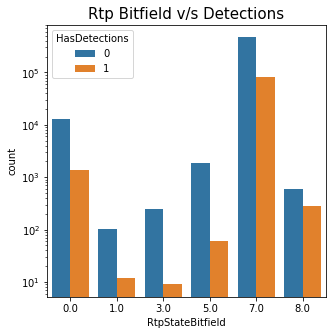

In [186]:
## Rtp State Bitfield v/s Target Detection (Rtp -->  a network transport protocol)
plt.figure(figsize = (5,5))
sns.countplot(x='RtpStateBitfield', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Rtp Bitfield v/s Detections', size=15)
plt.show()

Lot of machines have bitfield set as '7'. But from this histograph, it seems bitfield 1, 3, 5 seems to perform better wrt detections the machine has.

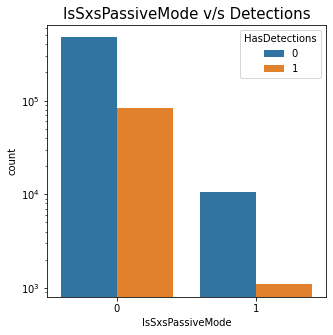

In [188]:
## SXS Passive Mode v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='IsSxsPassiveMode', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('IsSxsPassiveMode v/s Detections', size=15)
plt.show()

Passive Mode set to 1 seems to have better defence against detection, but then again due to less no of systems having mode = 1, we can't conclude

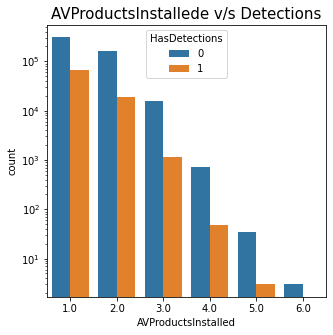

In [189]:
## No of AV Products installed v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='AVProductsInstalled', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('AVProductsInstallede v/s Detections', size=15)
plt.show()

From the above graph, it looks like the more AV Products are installed the better is the defence against malwares. But for this to conculde, we should consider whether all of them are enabled or not.

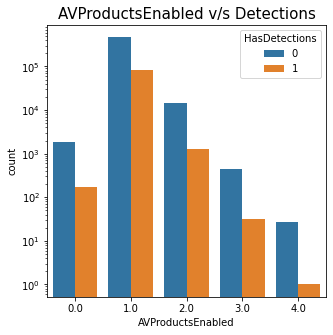

In [190]:
## No of AV Products enabled v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='AVProductsEnabled', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('AVProductsEnabled v/s Detections', size=15)
plt.show()

It looks as if when 4 AVProducts are enabled, the system seem to have better defence. 

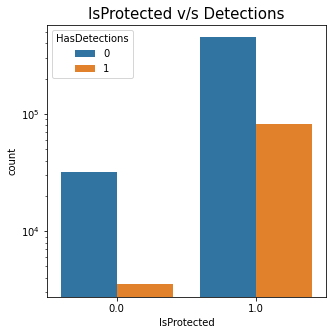

In [191]:
## IsProtected v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='IsProtected', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('IsProtected v/s Detections', size=15)
plt.show()

Assuming this feature is cummulative of info on AV Products Enabled, Virus defintion etc. The graph goes against common intitution that
it seems to have less detections when protection is turned off.

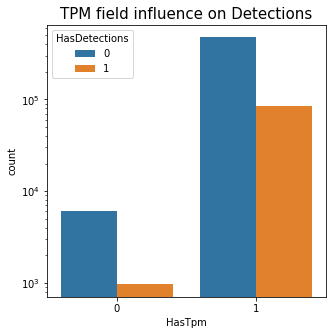

In [192]:
## TPM v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='HasTpm', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('TPM field influence on Detections', size=15)
plt.show()

From the above graph, there's not much difference in ratios of detections in both cases, but it detections are slightly less when Tpm is 0 compared to when its set to 1. 

#### Does Location of user has impact on No of Detections?

There are several features pertaining location of user/system -> <br> Country_Identifier, City_identifier, Geo_Name, Orgianization_Identifier, Locale_English_name, Region_identifier. 

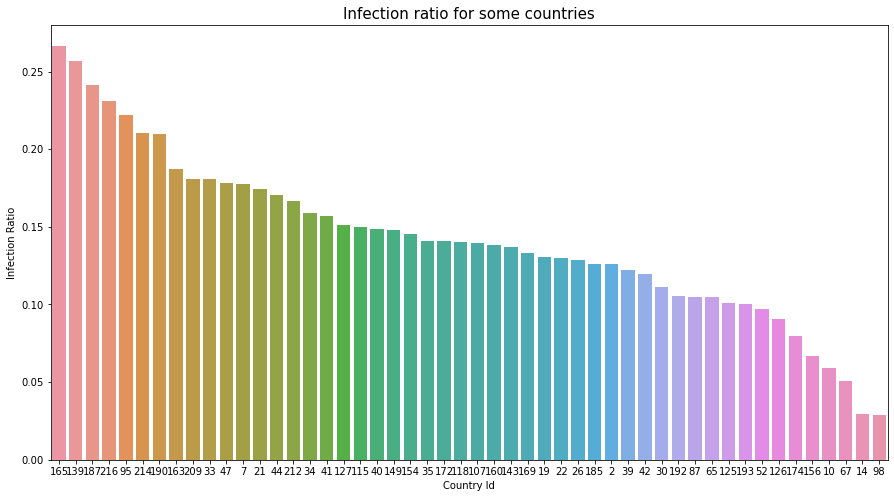

In [10]:
ratios = {}
for c in train['CountryIdentifier'].unique():
    df = train[train['CountryIdentifier'] == c]
    ratios[c] = sum(df['HasDetections']) / len(df)

data = pd.DataFrame({"Country Id": list(ratios.keys()), "Infection Ratio": list(ratios.values())}).sample(50).sort_values(by='Infection Ratio')
order = list(data['Country Id'])[::-1]

plt.figure(figsize=(15,8))
sns.barplot(x="Country Id", y="Infection Ratio", data=data, order=order)
plt.title('Infection ratio for some countries', size=15)
plt.show()

Since the country_ids are numerical, we can't interpret much about them. But from above graph we can conculde that country_id with 16 has highest infection ration, and country_id with 98 being with least.

So, location of user/system may play a role in predicting infections, since some countries may be underdevloped and hence have older systems, 
which are more prone to malware attacks. It can also be reasoned that rich countries invest more in cybersecurity, and hence have better defence against malwares.

#### Influence of choice of Operating system on infections

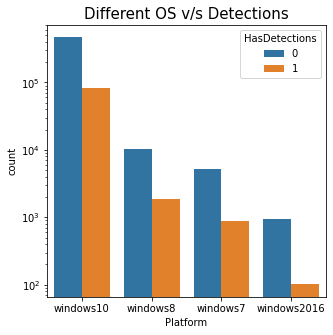

In [27]:
## OS v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='Platform', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Different OS v/s Detections', size=15)
plt.show()

Windows 2016 seems to have better infection ratio maybe because its a server edition and hence have better infrastructure of protection, others have almost same detection rates. It can also be seen that most people use windows 10 compared to others

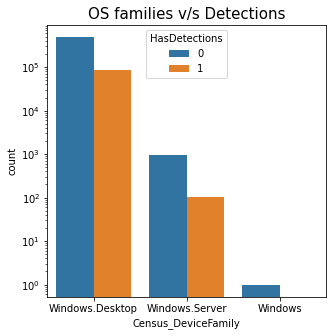

In [28]:
## OS family v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='Census_DeviceFamily', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('OS families v/s Detections', size=15)
plt.show()

The graph seems to agree with our previous reasoning that server OS silghtly have better protection

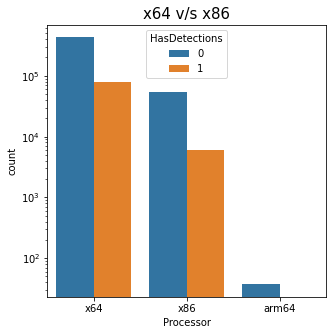

In [31]:
## processor architecture v/s no of Detections
plt.figure(figsize = (5,5))
sns.countplot(x='Processor', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('x64 v/s x86', size=15)
plt.show()

Both architecture seems to have alomst same infection ratio. By intiution x64 should perform better because its modern and would have better defence strategies against malwares. 

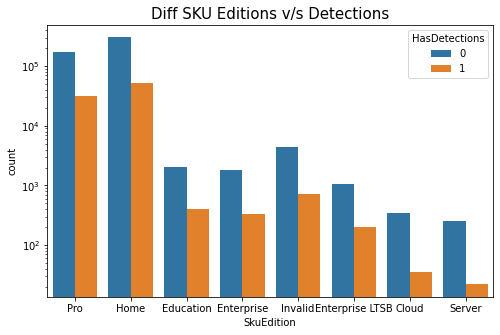

In [34]:
## Diff SKU - Editions (OS usage category) v/s Detections
plt.figure(figsize = (8,5))
sns.countplot(x='SkuEdition', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Diff SKU Editions v/s Detections', size=15)
plt.show()

Server & Cloud Editions seems to have better defence against malwares, reasoning can be that they are constantly updates with latest security patches and have better maintaince and infrastructure.

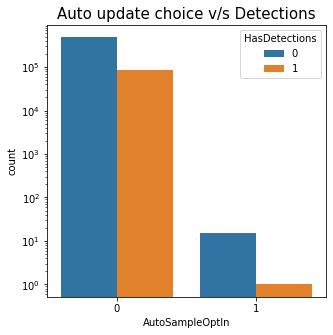

In [36]:
## Auto - updates opt in v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='AutoSampleOptIn', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Auto update choice v/s Detections', size=15)
plt.show()

As expected, most people have turned this feature off, but for those who have this option enabled, they seems to have better protection against malwares.

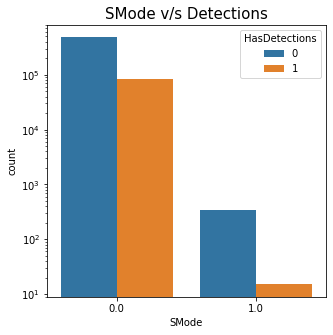

In [38]:
## PUA Mode v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='SMode', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('SMode v/s Detections', size=15)
plt.show()

SMode refers to option of having softwares downloaded only from official microsoft store. Hence for those with this option enabled, obviously they have less chance of getting malwares as compared to illegal sources.

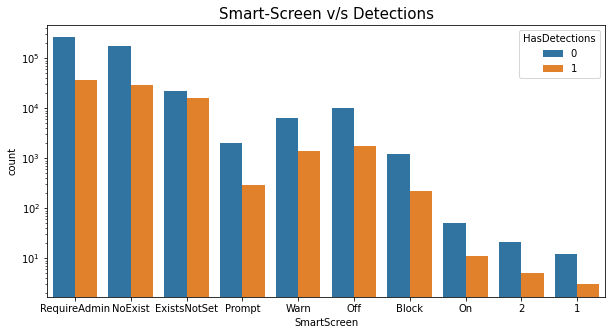

In [41]:
## Smart screen options v/s Detections
plt.figure(figsize = (10,5))
sns.countplot(x='SmartScreen', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Smart-Screen v/s Detections', size=15)
plt.show()

Smart-screen is primarily made to protect users from malwares, but here most options seems to have same infection rate.

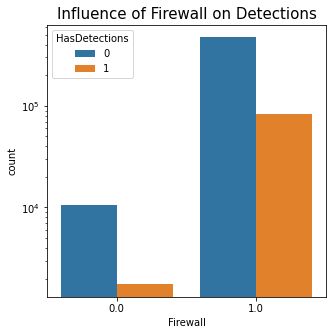

In [43]:
## Firewall options v/s Infections
plt.figure(figsize = (5,5))
sns.countplot(x='Firewall', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Influence of Firewall on Detections', size=15)
plt.show()

This result goes against common intituion that firewall would protect against malwares. Here firewall off has slightly better infection ratio, but most people have kept firewall turned on in their systems.

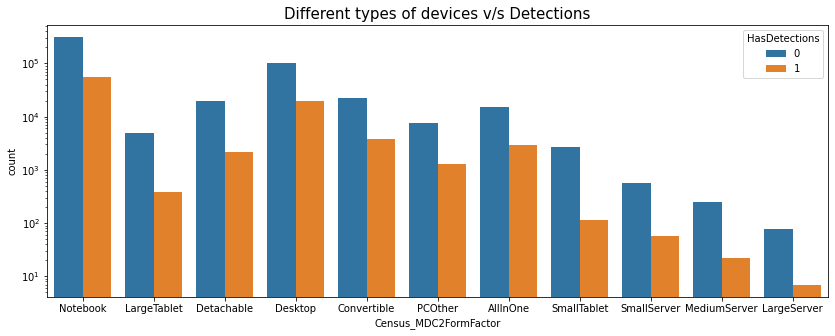

In [47]:
## Diff types of devices v/s Detections
plt.figure(figsize = (14,5))
sns.countplot(x='Census_MDC2FormFactor', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Different types of devices v/s Detections', size=15)
plt.show()

Here tablet and server devices seems to have better protection against malwares. It can be reasoned that these devices have different OS from traditional PCs hence its PC malwares cant infect them.

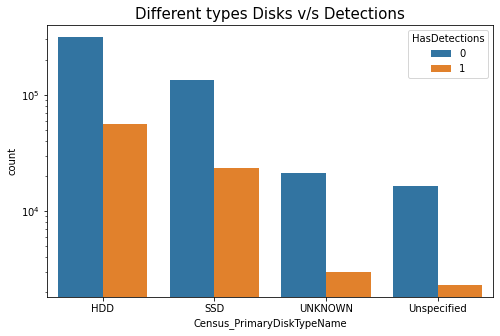

In [55]:
## Diff Disks v/s Detections
plt.figure(figsize = (8,5))
sns.countplot(x='Census_PrimaryDiskTypeName', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Different types Disks v/s Detections', size=15)
plt.show()

There doesn't seem to have much difference between HDD & SDD Systems. We can club Unknown & Unspecified into single value. 

In [10]:
conversion_dict = {
    'UNKNOWN': 'unknown', 'Unspecified': 'unknown'
}
train.replace({'Census_PrimaryDiskTypeName': conversion_dict}, inplace=True)
test.replace({'Census_PrimaryDiskTypeName': conversion_dict}, inplace=True)

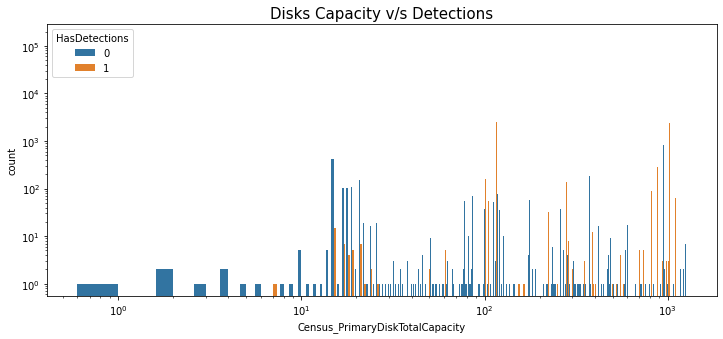

In [57]:
plt.figure(figsize = (12,5))
sns.countplot(x='Census_PrimaryDiskTotalCapacity', hue='HasDetections', data = train)
plt.yscale('log')
plt.xscale('log')
plt.title('Disks Capacity v/s Detections', size=15)
plt.show()

System with Larger size disks have more infections. This can be reasoned as - the more the disk space, the user uses more internet/downloading/softwares, hence he is more prone to get malware

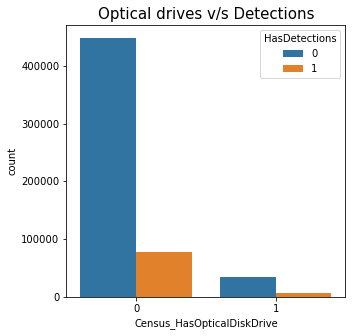

In [65]:
plt.figure(figsize = (5,5))
sns.countplot(x='Census_HasOpticalDiskDrive', hue='HasDetections', data = train)
plt.title('Optical drives v/s Detections', size=15)
plt.show()

Systems without optical drives have better infection protection. This feature may seem it has no effect on malwares, but indirectly systems which have optical drives mean older devices, hence they are more prone to malware attacks. <br>
Similarly all these Census System hardware resource info may not have direct impact on malware infections. But they tell important info on what type of system it is, like whether its old or modern. Based on that the ML algorithm can get vital insight into the type/generation of system and prone it is against malware attacks.

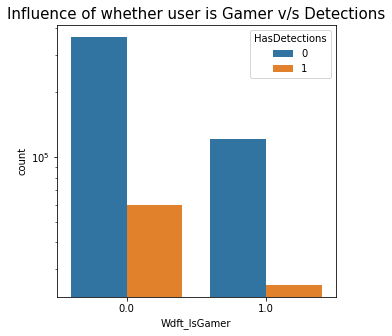

In [67]:
plt.figure(figsize = (5,5))
sns.countplot(x='Wdft_IsGamer', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Influence of whether user is Gamer v/s Detections', size=15)
plt.show()

This feature is important because if the user is Gamer, he downloads more software, and is connected to internet more often, hence he is more prone to malware attacks. This also agrees with above graph that Gamers are more prone to attacks.

In [12]:
train['IsBeta'].value_counts()

0    567726
1         4
Name: IsBeta, dtype: int64

There are two few softwares in Beta version, hence this feature is useless. We can drop this from train & test datasets.

In [11]:
train.drop('IsBeta', axis=1, inplace=True)
test.drop('IsBeta', axis=1, inplace=True)

### Skew Analysis

Skew parameter of each feature column:

In [73]:
#train.skew(axis=0, skipna=True).sort_values(ascending = True)

sk = pd.DataFrame([{'column': c, 'skew': train[c].value_counts(normalize=True).values[0] * 100} for c in train.columns])
sk.sort_values(by='skew', ascending=False).head(20)

,column,skew
72,Census_IsWIMBootEnabled,100.000000
65,Census_IsFlightingInternal,99.999824
66,Census_IsFlightsDisabled,99.998239
26,AutoSampleOptIn,99.997182
68,Census_ThresholdOptIn,99.990488
62,Census_IsPortableOperatingSystem,99.953323
27,SMode,99.935885
33,Census_DeviceFamily,99.815053
31,UacLuaenable,99.402533
73,Census_IsVirtualDevice,98.996002


As we can see some features are have very large skewness. Some of them have almost 99% skew in them, meanining almost all values are of only few categories. This high skew features won't help much for learning algorithm since it won't add much info to learning. Hence, we shall drop these skewed columns (skew > 99%) from dataset. 

In [12]:
skewed_features = ["Census_IsWIMBootEnabled", "Census_IsFlightingInternal", "Census_IsFlightsDisabled", "AutoSampleOptIn", "Census_ThresholdOptIn", "Census_IsPortableOperatingSystem", "SMode", "Census_DeviceFamily", "UacLuaenable", "Census_IsVirtualDevice", "ProductName"]
train.drop(skewed_features, axis=1, inplace=True)
test.drop(skewed_features, axis=1, inplace=True)

#### Checking Correaltion of numerical features

Groupping columns into small sets of 20 features each for correlation analysis

In [13]:
cols = train.columns.tolist()

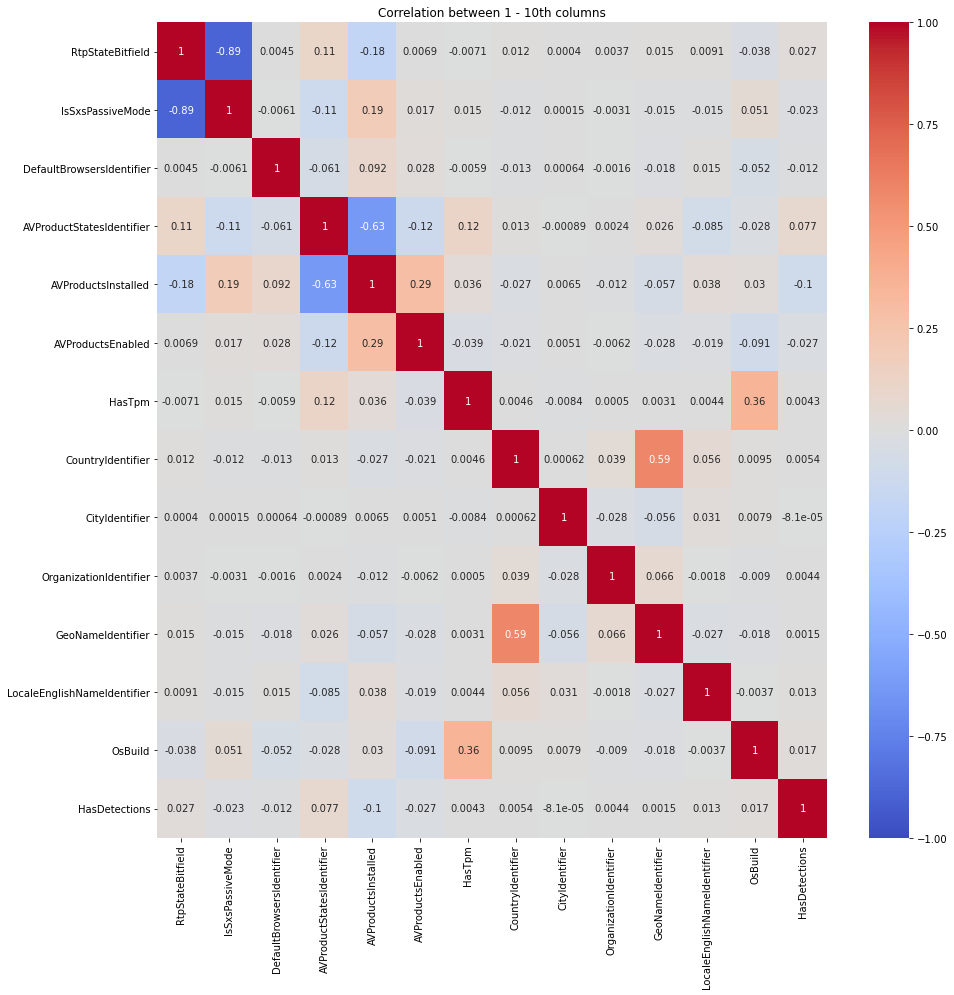

In [79]:
## correlation between first 20 features & target detection column
plt.figure(figsize=(15,15))
cols_1_20 = cols[:20]
cols_1_20.append('HasDetections')
sns.heatmap(train[cols_1_20].corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.title('Correlation between 1 - 10th columns')
plt.show()

Features "RtpStateBitField" and "IsSXSPassiveMode" have relatively high correlation (-0.89). It is to be noted here that these two are negatively correlated. We shall drop feature which has less unique values among these two.

In [80]:
print("Unique values in RtpStateBitfield: ", train.RtpStateBitfield.nunique())
print("Unique values in IsSxsPassiveMode: ", train.IsSxsPassiveMode.nunique())

Unique values in RtpStateBitfield:  6
Unique values in IsSxsPassiveMode:  2


In [14]:
## Removing IsSxsPassiveMode feature from train and test datasets
train.drop('IsSxsPassiveMode', axis=1, inplace=True)
test.drop('IsSxsPassiveMode', axis=1, inplace=True)

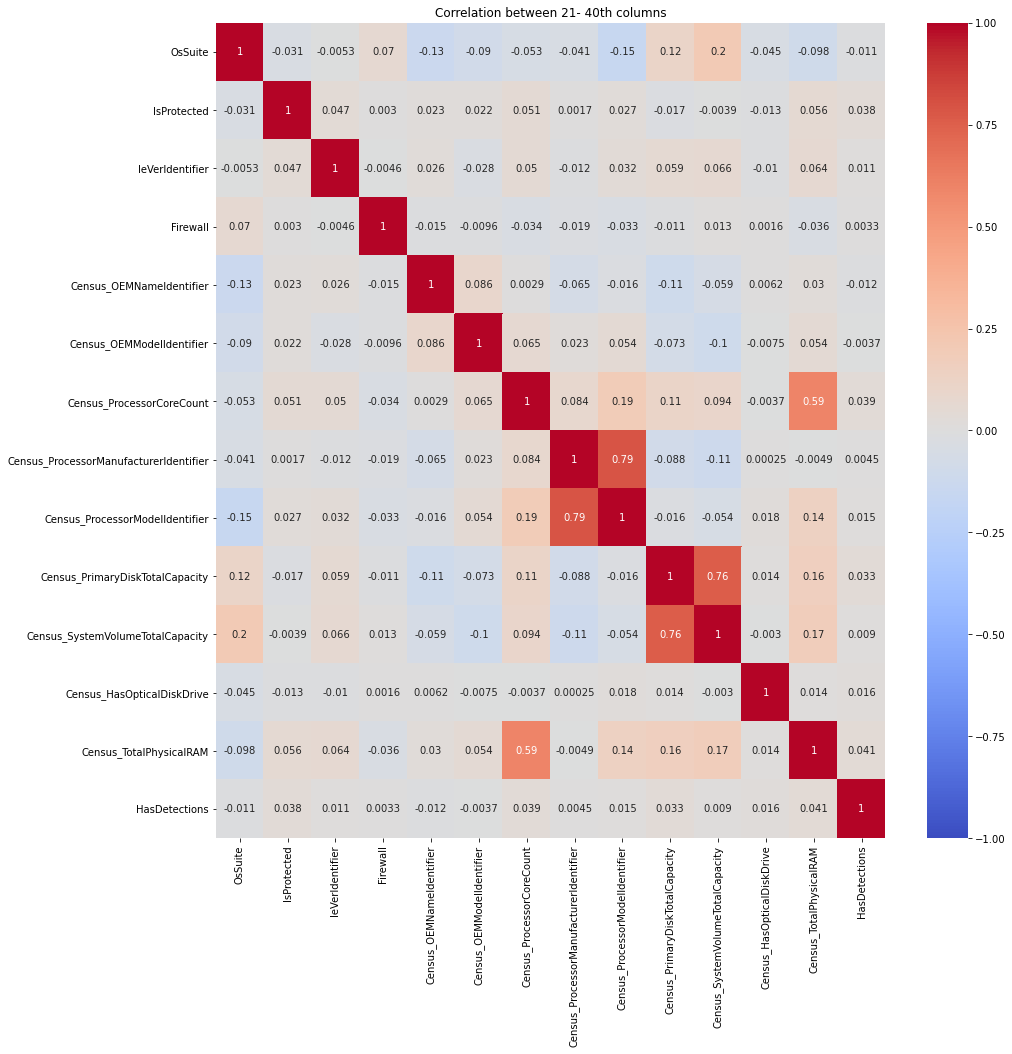

In [82]:
## correlation between 21-40 features & target detection column
plt.figure(figsize=(15,15))
cols_21_40 = cols[20:40]
cols_21_40.append('HasDetections')
sns.heatmap(train[cols_21_40].corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.title('Correlation between 21- 40th columns')
plt.show()

There's slight correlation between "Processor model identifier" & "Processor manufacturer identifier". And also they seem to have similar meaning, hence we shall drop one of them from datasets. Similarly for Sytem Volume Capacity & Primary Disk Capacity.

In [15]:
train.drop('Census_ProcessorManufacturerIdentifier', axis=1, inplace=True)
test.drop('Census_ProcessorManufacturerIdentifier', axis=1, inplace=True)
train.drop('Census_PrimaryDiskTotalCapacity', axis=1, inplace=True)
test.drop('Census_PrimaryDiskTotalCapacity', axis=1, inplace=True)

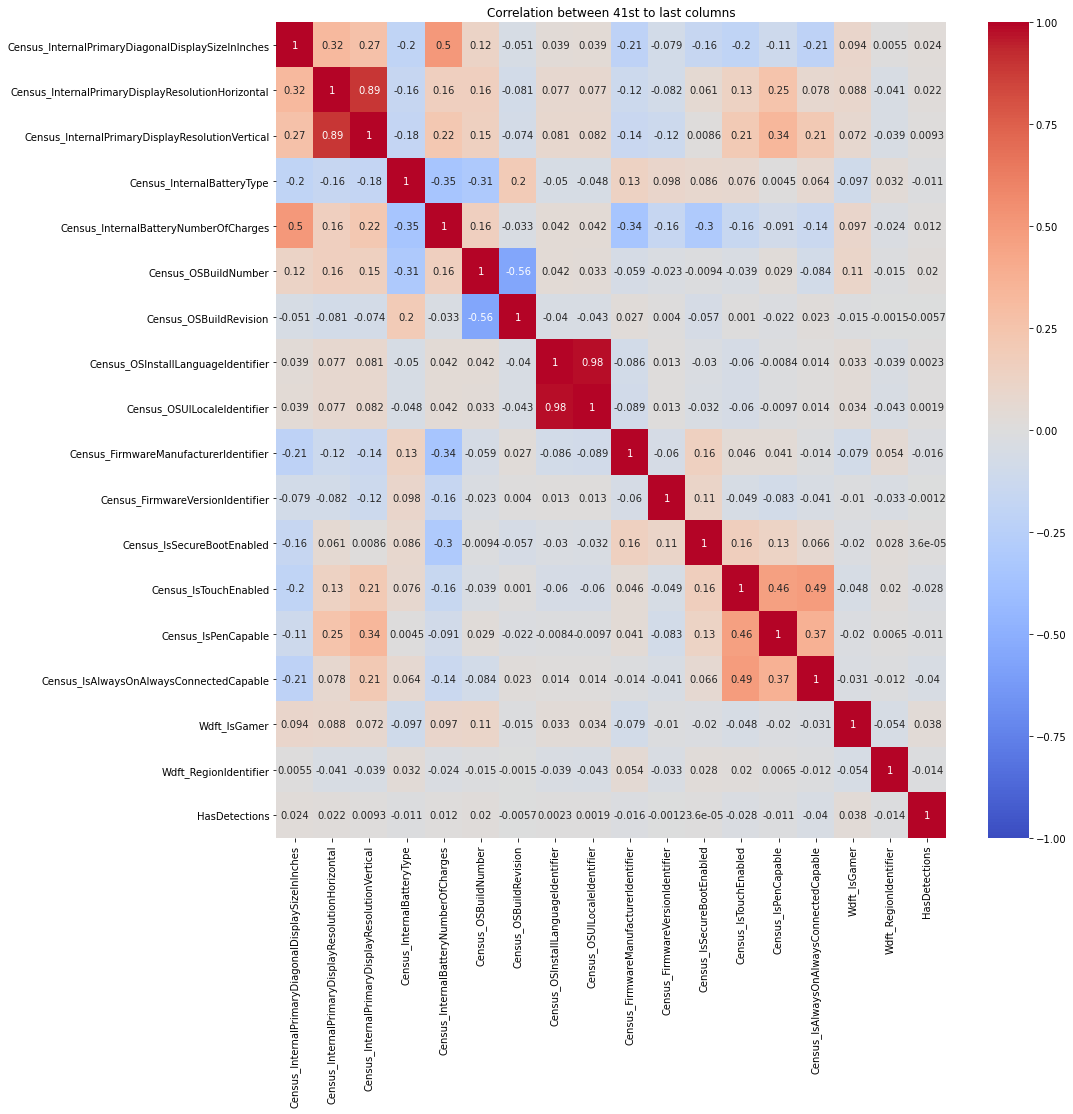

In [88]:
## correlation between 41 to last feature & target detection column
plt.figure(figsize=(15,15))
cols_41_last = cols[40:]
sns.heatmap(train[cols_41_last].corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.title('Correlation between 41st to last columns')
plt.show()

There's high correlation between feature "Vertical Resolution of display" & "Horizontal Resolution of display". We will remove one which has less unique values. Similarly Features "Census_OSUILocaleIdentifier" & "Census_OSInstallLanguageIdentifier" are almost perfectly correlated (corr = 0.98). Here the latter column has less unique values, so it makes sense to drop the column

In [16]:
train.drop('Census_InternalPrimaryDisplayResolutionVertical', axis=1, inplace=True)
test.drop('Census_InternalPrimaryDisplayResolutionVertical', axis=1, inplace=True)
train.drop('Census_OSInstallLanguageIdentifier', axis=1, inplace=True)
test.drop('Census_OSInstallLanguageIdentifier', axis=1, inplace=True)

### Preprocessing & Encoding of Categorical features / Feature Engineering

For converting categorical values into numerical, we will be using Frequency encoding, which gives numnerical value according to frequency(no of times) the particular value occurs in the column. some other features we will also be using Label Encoding.

In [17]:
## Feature encoding of categorical columns
frequency_encoded = ['OsPlatformSubRelease', 'OsBuildLab', 'Processor', 'SkuEdition', 'SmartScreen', 'Platform']

def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

for variable in frequency_encoded:
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))

Features like App version, Os_version have values like 1.2.3.45, from which we would remove '.' char to make it easier for learning algorithm.

In [18]:
## Removing special chars from some features
train['EngineVersion'] = train['EngineVersion'].str.replace('[.]', '')
train['AppVersion'] = train['AppVersion'].str.replace('[.]', '')
train['AvSigVersion'] = train['AvSigVersion'].str.replace('[.]', '')
train['OsVer'] = train['OsVer'].str.replace('[.]', '')
test['EngineVersion'] = train['EngineVersion'].str.replace('[.]', '')
test['AppVersion'] = train['AppVersion'].str.replace('[.]', '')
test['AvSigVersion'] = train['AvSigVersion'].str.replace('[.]', '')
test['OsVer'] = train['OsVer'].str.replace('[.]', '')

We shall drop Machine_Identifier column for now since it doesn't provide any valuable info to model. Since it is required at submission, we will attach this column later to final results.

In [19]:
## Machine id is a hash value and is no use to feed  it to learning algorithm
machine_id = test_tar['MachineIdentifier']
train.drop('MachineIdentifier', axis=1, inplace=True)
test.drop('MachineIdentifier', axis=1, inplace=True)

Census_Chassis_Type contains vague values, and by common intiution it doesn't seem to matter for malware detection. Hence we will drop this from both train and test datasets. OS_version feature is repeated twice, hence we will drop on of them.

In [20]:
train.drop('Census_ChassisTypeName',  axis=1, inplace=True)
test.drop('Census_ChassisTypeName',  axis=1, inplace=True)
## OS_Ver are repeated
train.drop('Census_OSVersion',  axis=1, inplace=True)
test.drop('Census_OSVersion',  axis=1, inplace=True)

For the features which we removed special chars and also some census features we will apply Label encoding to convert categorical values in them to numerical.

In [21]:
## Label Encoding of remaining Census categorical columns

from sklearn.preprocessing import LabelEncoder
feature_encoded = ['Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName', 'Census_PowerPlatformRoleName', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer']
for feature in feature_encoded:
    train[feature] = LabelEncoder().fit_transform(train[feature])
    test[feature] = LabelEncoder().fit_transform(test[feature])

##### Standardizing values

In [22]:
train_db = train.copy()
test_db = test.copy()

In [23]:
## Leaving target column out of Standardization
target_column = train_db['HasDetections']
train_db.drop('HasDetections', axis=1, inplace=True)

Since values of different columns have varying range of values, we will use Standard Scalar to scale all the values. Standard Scalar also rescales values to mean of 0 and standard deviation of 1.

In [24]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
train_db = pd.DataFrame(std_scaler.fit_transform(train_db), columns=train_db.columns)
test_db = pd.DataFrame(std_scaler.fit_transform(test_db), columns=test_db.columns)

In [25]:
## Merging back target column to training dataset
train_db = pd.concat([train_db, target_column], axis = 1)

### Handling Imbalance dataset

In [26]:
train_db['HasDetections'].value_counts()

0    482571
1     85159
Name: HasDetections, dtype: int64

Based on Target column train dataaset is imbalanced to (6:1 ratio). Most of the records are for no-detection class . i.e almost 6 times the no of records which have detection as true.

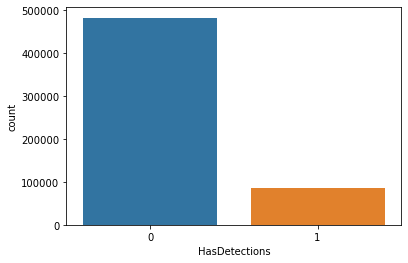

In [54]:
sns.countplot(train_db['HasDetections'])
plt.show()

### Applying Learning Algorithm 

In [27]:
## extracting target column from train data
target = train_db['HasDetections']
## removing target column from train data
train_db.drop('HasDetections', axis=1, inplace=True)

##### Stratified sampling (Taking subset of train dataset)

In [32]:
from sklearn.model_selection import train_test_split
x_unselected, x_selected, y_unselected, y_selected = train_test_split(train_db, target, stratify=target, random_state=123, test_size=0.02)

##### Using SMOTE for balancing minory class by oversampling

In [34]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 101)
X_oversample, Y_oversample = smote.fit_resample(x_selected, y_selected)


In [37]:
Y_oversample.value_counts()

1    9652
0    9652
Name: HasDetections, dtype: int64

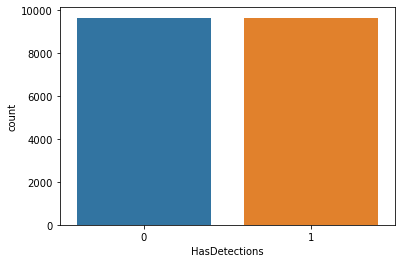

In [47]:
sns.countplot(Y_oversample)
plt.show()

Dataset is not balanced by oversampling minority class

##### Training on SVM with linear kernel

In [39]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_oversample, Y_oversample)


SVC(kernel='linear')

In [40]:
result = clf.predict(test_db)

In [41]:
df = pd.DataFrame(result)

In [42]:
res = pd.concat([machine_id, df], axis = 1)

In [43]:
res.to_csv('submission_kaggle.csv')